In [44]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")

Using device: cuda

GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import functools
from PIL import Image
import argparse
import os
import numpy as np
import random
import time
import datetime
import json
from pathlib import Path


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import transformers

In [48]:
from PIL import Image
from torchvision import transforms
from core.ofa import OFATokenizer, OFAModel
from core.ofa.generate import sequence_generator

In [49]:
from transformers import (
    HfArgumentParser,
    TrainingArguments,
)

In [53]:
from ctl.vqa_arguments import VQAArguments

In [68]:
from core.ofa.modeling_ofa import OFAModelForVQA

In [60]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 480

In [61]:
patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/srv/share2/sanisetty3/miniconda3/envs/DLM/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [12]:
pwd

'/coc/scratch/sanisetty3/DLM/OFA_VQA'

In [63]:
ckpt_dir='./OFA-tiny'
tokenizer = OFATokenizer.from_pretrained(ckpt_dir)

./OFA-tiny
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [64]:
txt = "How many blocks are there?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
img = Image.open('./samples/i1.jpeg')
patch_img = patch_resize_transform(img).unsqueeze(0)

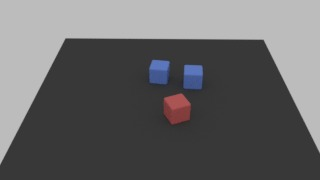

In [65]:
img

In [69]:
model = OFAModelForVQA.from_pretrained(ckpt_dir, use_cache=False)

In [70]:
check = torch.load("./OFA-tiny/pytorch_model.bin")

In [23]:
gen = model.generate(inputs, patch_images=patch_img, num_beams=5, no_repeat_ngram_size=3)

In [18]:
import transformers

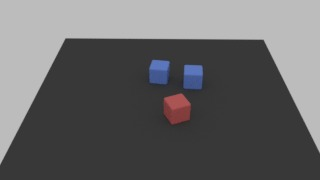

2


In [24]:
display(img)
print(tokenizer.batch_decode(gen, skip_special_tokens=True)[0].strip())

In [24]:
batch = {
            "input_ids": inputs,
            "patch_images":patch_img,
            'return_loss': True,
            "target" :inputs,

        }

In [21]:
def f(input_ids,patch_images,return_loss,defrw = 6):
    print(input_ids.shape)
    print(patch_images.shape)
    print(return_loss)

In [25]:
f(**batch)

TypeError: f() got an unexpected keyword argument 'target'

In [71]:
tokenizer(["" , ''], return_tensors="pt").input_ids

tensor([[0, 2],
        [0, 2]])

In [31]:
inputs = tokenizer([" What is your name" , "hand" , ""], return_tensors="pt" , max_length=128, truncation=True, padding=True)

In [36]:
input1 = tokenizer([" What is your name"], return_tensors="pt" , max_length=128, truncation=True, padding=True).input_ids
input2 = tokenizer([" hand"], return_tensors="pt" , max_length=128, truncation=True, padding=True).input_ids

In [82]:
input1[0]

tensor([  0, 653,  16, 110, 766,   2])

In [46]:
pad = torch.LongTensor([1])

In [50]:
[s.ne(pad).long().sum() for s in inputs.input_ids]

[tensor(6), tensor(3), tensor(2)]

In [32]:
inputs.attention_mask

tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0],
        [1, 1, 0, 0, 0, 0]])

In [43]:
inputs.input_ids

tensor([[   0,  653,   16,  110,  766,    2],
        [   0, 4539,    2,    1,    1,    1],
        [   0,    2,    1,    1,    1,    1]])

In [54]:
bos = torch.LongTensor([tokenizer.bos_token_id])

In [68]:
bos.tolist()

[0]

In [89]:
torch.repeat_interleave(bos , len(inputs)).reshape(-1,1)[:, 1:]

tensor([], size=(2, 0), dtype=torch.int64)

In [72]:
def collate_tokens(
    values,
    pad_idx,
    eos_idx=None,
    left_pad=False,
    move_eos_to_beginning=False,
    pad_to_length=None,
    pad_to_multiple=1,
    pad_to_bsz=None,
):
    """Convert a list of 1d tensors into a padded 2d tensor."""
    size = max(v.size(0) for v in values)
    size = size if pad_to_length is None else max(size, pad_to_length)
    if pad_to_multiple != 1 and size % pad_to_multiple != 0:
        size = int(((size - 0.1) // pad_to_multiple + 1) * pad_to_multiple)

    def copy_tensor(src, dst):
        assert dst.numel() == src.numel()
        if move_eos_to_beginning:
            if eos_idx is None:
                # if no eos_idx is specified, then use the last token in src
                dst[0] = src[-1]
            else:
                dst[0] = eos_idx
            dst[1:] = src[:-1]
        else:
            dst.copy_(src)

    if values[0].dim() == 1:
        res = values[0].new(len(values), size).fill_(pad_idx)
    elif values[0].dim() == 2:
        assert move_eos_to_beginning is False
        res = values[0].new(len(values), size, values[0].size(1)).fill_(pad_idx)
    else:
        raise NotImplementedError

    for i, v in enumerate(values):
        copy_tensor(v, res[i][size - len(v) :] if left_pad else res[i][: len(v)])
    return res

In [84]:
inputs = tokenizer([" What is your name" , " hand"], return_tensors="pt" , max_length=128, truncation=True, padding=True)

In [86]:
collate_tokens(
            [bos,bos],
            1,
            eos_idx=2,
        )

tensor([[0],
        [0]])

In [85]:
inputs.input_ids

tensor([[  0, 653,  16, 110, 766,   2],
        [  0, 865,   2,   1,   1,   1]])